In [110]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pdb
import math
import random

In [111]:
import torch
torch.cuda.is_available()

False

In [127]:
Npoints = 1000
x = torch.rand(Npoints,1).sort(dim=0)[0]

In [128]:
def mean_curve(x):
    return torch.sin(10*x)
def std_curve(x, par):
    return torch.sqrt(var_curve(x, par))
def var_curve(x, par):
    return par * par * torch.abs(torch.cos(10*x))
def confidence_95(x, par):
    return torch.column_stack([mean_curve(x)+1.96*std_curve(x,par), mean_curve(x)-1.96*std_curve(x,par)])
def generate_noise(x, par):
    torch.manual_seed(0)
    random.seed(0)
    np.random.seed(0)
    
    eps1 = torch.randn(Npoints,1)+2
    eps2 = torch.randn(Npoints,1)-2
    eps3 = (torch.rand(Npoints,1)>0.5).int()
    eps4 = 1 - eps3
    
    eps = (eps1*eps3+eps2*eps4) / np.sqrt(5)
    #eps = torch.randn(Npoints,1)
    return std_curve(x,par) * eps
def generate_data(x, par):
    return mean_curve(x) + generate_noise(x, par)
def MSE_min(x, par):
    return var_curve(x,par).mean()
def Gauss_min(x, par):
    return 0.5 + 0.5 * torch.log(var_curve(x,par)).mean()

In [129]:
def custom_mse(net,x,y):
    with torch.no_grad():
        yhat = net.forward(x)
        if net.ANN_type == 'MSE':
            return torch.square(yhat-y).mean()
        elif net.ANN_type == 'Gauss':
            return torch.square(yhat[:,0:1]-y).mean()

In [130]:
def custom_gauss(net,x,y):
    with torch.no_grad():
        yhat = net.forward(x)
        term1 = torch.log(yhat[:,1:2])
        term2 = torch.div(torch.square(y-yhat[:,0:1]), yhat[:,1:2])
        return 0.5 * (term1 + term2).mean()    

In [131]:
pars = [0.01, 1]

In [132]:
for par in pars:
    print(f'data var = {generate_data(x,par).var()},MSE min = {MSE_min(x,par)}, Gauss min = {Gauss_min(x,par)}')

data var = 0.42876124382019043,MSE min = 6.680032674921677e-05, Gauss min = -4.420815467834473
data var = 1.113415241241455,MSE min = 0.6680033206939697, Gauss min = 0.18435466289520264


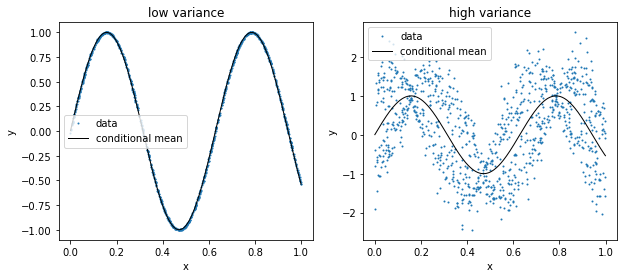

In [230]:
def plot_data(x,par,title):
    y = generate_data(x,par)
    plt.plot(x,y,'.',markersize=2)
    plt.plot(x,mean_curve(x),'k-',linewidth=1)
    #plt.plot(x,confidence_95(x,par),'k--',linewidth=1)
    plt.legend(['data', 'conditional mean', '95% confidence interval'])
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(title)

fig = plt.figure(figsize=(10,4))
plt.subplot(121)
plot_data(x,pars[0],title='low variance')
plt.subplot(122)
plot_data(x,pars[1],title='high variance')

In [134]:
class Net(nn.Module):
    def __init__(self, width, depth, ANN_type='MSE'):
        super().__init__()
        
        blocks = []
        blocks.extend([nn.Linear(1,width), nn.ReLU()])
        for j in range(depth-2):
            blocks.extend([nn.Linear(width,width), nn.ReLU()])
        
        self.ANN_type = ANN_type
        if ANN_type == 'MSE':
            blocks.append(nn.Linear(width,1))
        elif ANN_type == 'Gauss':
            blocks.append(nn.Linear(width,2))
        
        self.my_net = nn.Sequential(*blocks)
    
    def forward(self,x):
        x = self.my_net(x)
        if self.ANN_type == 'MSE':
            return x
        if self.ANN_type == 'Gauss':
            xx = torch.zeros_like(x)
            xx[:,0] = x[:,0]
            xx[:,1] = nn.functional.softplus(x[:,1]) 
            return xx
    
    def mean_curve(self, x):
        with torch.no_grad():
            yhat = self.forward(x)
            return yhat[:,0:1]
    
    def var_curve(self, x):
        with torch.no_grad():
            yhat = self.forward(x)
            return yhat[:,1:2]
        
    def generate_noise(self,x):
        with torch.no_grad():
            yhat = self.forward(x)
            std_hat = torch.sqrt(yhat[:,1:2])
            noise = std_hat * torch.randn(std_hat.shape)
            return noise
    def var_mean(self,x):
        with torch.no_grad():
            yhat = self.forward(x)
            var_hat = yhat[:,1:2]
            return var_hat.mean()
    def log_var_mean(self,x):
        with torch.no_grad():
            yhat = self.forward(x)
            var_hat = yhat[:,1:2]
            return 0.5 + 0.5 * torch.log(var_hat).mean()
        
    def generate_data(self,x):
        with torch.no_grad():
            yhat = self.forward(x)
            std_hat = torch.sqrt(yhat[:,1:2])
            noise = std_hat * torch.randn(std_hat.shape)
            return yhat[:,0:1] + noise

In [135]:
def regularization(yhat, ytrue):
    var_vector = yhat[:,1:2]
    mean_vector = yhat[:,0:1]
    mse = torch.square(mean_vector-ytrue).mean()
    noise_var = var_vector.mean()
    return torch.square(mse - noise_var)

In [136]:
def minibatch(net, x, y, batch_size=64):
    idx = np.arange(x.shape[0])
    np.random.shuffle(idx)
    batches = x.shape[0] // batch_size
    if (batches * batch_size < x.shape[0]):
        batches += 1
    for batch in range(batches):
        idxx = idx[batch*batch_size:(batch+1)*batch_size]
        xx = x[idxx]
        yy = y[idxx]
        yield xx,yy

In [137]:
def train(net, x, y, lr=0.001, num_epochs=100, batch_size=64):    
    optimizer = optim.Adam(net.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[int(num_epochs/2), int(num_epochs*3/4), int(num_epochs*7/8)], gamma=0.1)
    criterion = nn.MSELoss()
    
    net.loss_history = {'mse': [], 'custom_mse': []}
    
    for epoch in range(num_epochs):
        epoch_loss = 0.
        epoch_weight = 0.
        for xx, yy in minibatch(net, x, y, batch_size):
            optimizer.zero_grad()
            yhat = net.forward(xx)
            loss = criterion(yhat, yy)
            loss.backward()
            optimizer.step()
            
            nb = xx.shape[0]
            epoch_loss += nb * loss.item()
            epoch_weight += nb
        net.loss_history['mse'].append(epoch_loss/epoch_weight)
        net.loss_history['custom_mse'].append(custom_mse(net,x,y).item())
        scheduler.step()
        if epoch % 10 == 0:
            print(f"epoch = {epoch}, numpoints = {epoch_weight}, MSE = {epoch_loss/epoch_weight}")

In [138]:
def train_probabilistic(net, x, y, lr=0.001, num_epochs=100, batch_size=64, alpha = 0.):    
    optimizer = optim.Adam(net.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[int(num_epochs/2), int(num_epochs*3/4), int(num_epochs*7/8)], gamma=0.1)
    criterion = nn.GaussianNLLLoss()

    
    net.loss_history = {'gauss': [], 'custom_mse': [], 'custom_gauss': [], 'var_mean': [], 'log_var_mean': []}
    
    for epoch in range(num_epochs):
        epoch_loss = 0.
        epoch_weight = 0.
        for xx, yy in minibatch(net, x, y, batch_size):
            optimizer.zero_grad()
            yhat = net.forward(xx)
            loss = criterion(yhat[:,0:1], yy, yhat[:,1:2]) + \
                alpha * regularization(yhat, yy)
            loss.backward()
            optimizer.step()
            
            nb = xx.shape[0]
            epoch_loss += nb * loss.item()
            epoch_weight += nb
        net.loss_history['gauss'].append(epoch_loss/epoch_weight)
        net.loss_history['custom_mse'].append(custom_mse(net,x,y).item())
        net.loss_history['custom_gauss'].append(custom_gauss(net,x,y).item())
        net.loss_history['var_mean'].append(net.var_mean(x))
        net.loss_history['log_var_mean'].append(net.log_var_mean(x))
        scheduler.step()
        if epoch % 10 == 0:
            print(f"epoch = {epoch}, numpoints = {epoch_weight}, Gaussian Loss = {epoch_loss/epoch_weight}")

In [231]:
net = Net(100,10); par = pars[1]

In [232]:
train(net, x, generate_data(x,par), lr = 0.001, num_epochs=100, batch_size=64)

epoch = 0, numpoints = 1000.0, MSE = 1.1166649284362793
epoch = 10, numpoints = 1000.0, MSE = 0.8027656445503235
epoch = 20, numpoints = 1000.0, MSE = 0.7810410079956055
epoch = 30, numpoints = 1000.0, MSE = 0.7233201398849487
epoch = 40, numpoints = 1000.0, MSE = 0.7128240585327148
epoch = 50, numpoints = 1000.0, MSE = 0.6978872103691101
epoch = 60, numpoints = 1000.0, MSE = 0.6863094639778137
epoch = 70, numpoints = 1000.0, MSE = 0.6841926078796386
epoch = 80, numpoints = 1000.0, MSE = 0.6810827407836914
epoch = 90, numpoints = 1000.0, MSE = 0.6807806539535523


Text(0.5, 1.0, 'MSE')

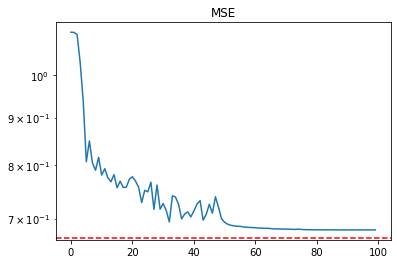

In [233]:
plt.semilogy(net.loss_history['custom_mse'])
plt.axhline(y=MSE_min(x,par),linestyle='--',color='r')
plt.title('MSE')

In [191]:
with torch.no_grad():
    yhat = np.array(net.forward(x))

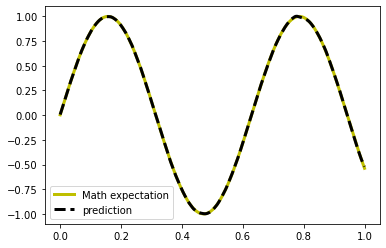

In [192]:
plt.plot(x,mean_curve(x),'y-', linewidth=3)
plt.plot(x,yhat,'k--',linewidth=3)
plt.legend(['Math expectation', 'prediction'])

In [234]:
pnet = Net(100,10,ANN_type='Gauss'); par = pars[1]

In [235]:
train_probabilistic(pnet, x, generate_data(x,par), lr = 0.001, num_epochs=100, batch_size=64, alpha=0.)

epoch = 0, numpoints = 1000.0, Gaussian Loss = 0.6060212984085083
epoch = 10, numpoints = 1000.0, Gaussian Loss = 0.555193190574646
epoch = 20, numpoints = 1000.0, Gaussian Loss = 0.5505466179847718
epoch = 30, numpoints = 1000.0, Gaussian Loss = 0.35830097007751466
epoch = 40, numpoints = 1000.0, Gaussian Loss = 0.25244111752510073
epoch = 50, numpoints = 1000.0, Gaussian Loss = 0.23108678710460662
epoch = 60, numpoints = 1000.0, Gaussian Loss = 0.2135301399230957
epoch = 70, numpoints = 1000.0, Gaussian Loss = 0.2070959095954895
epoch = 80, numpoints = 1000.0, Gaussian Loss = 0.20365615630149841
epoch = 90, numpoints = 1000.0, Gaussian Loss = 0.20336642497777938


Text(0.5, 0, 'epoch')

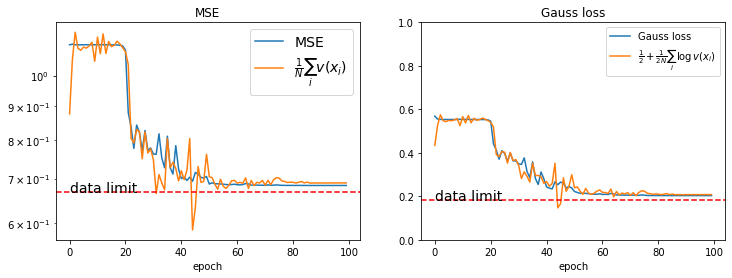

In [236]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.semilogy(pnet.loss_history['custom_mse'])
plt.semilogy(pnet.loss_history['var_mean'],'-', markersize=2)
plt.legend(['MSE', r'$\frac{1}{N}\sum_i v(x_i)$'], fontsize=14)
plt.xlabel('epoch')
plt.axhline(y=MSE_min(x,par),linestyle='--',color='r')
plt.text(x=0, y=MSE_min(x,par), s='data limit', fontsize=14)
#plt.ylim([1e-5,1e0])
plt.title('MSE')
plt.subplot(122)
plt.plot(pnet.loss_history['custom_gauss'])
plt.plot(pnet.loss_history['log_var_mean'],'-',markersize=2)
plt.ylim([0,1])
plt.legend(['Gauss loss', r'$\frac{1}{2} + \frac{1}{2N}\sum_i \log v(x_i)$'])
plt.axhline(y=Gauss_min(x,par),linestyle='--',color='r')
plt.text(x=0, y=Gauss_min(x,par), s='data limit', fontsize=14)
plt.title('Gauss loss')
plt.xlabel('epoch')

Text(0.5, 0, 'x')

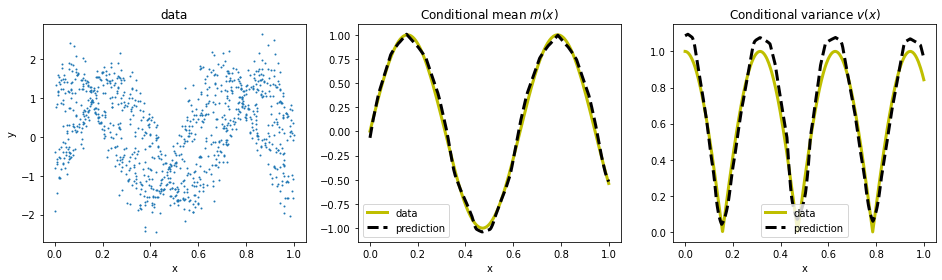

In [229]:
plt.figure(figsize=(16,4))
plt.subplot(131)
y = generate_data(x,par)
plt.plot(x,y,'.',markersize=2)
plt.xlabel('x')
plt.ylabel('y')
plt.title('data')
plt.subplot(132)
plt.plot(x,mean_curve(x),'y-', linewidth=3)
plt.plot(x,pnet.mean_curve(x),'k--',linewidth=3)
plt.legend(['data', 'prediction'])
plt.xlabel('x')
plt.title(r'Conditional mean $m(x)$')
plt.subplot(133)
plt.plot(x,var_curve(x,par),'y-', linewidth=3)
plt.plot(x,pnet.var_curve(x),'k--',linewidth=3)
plt.legend(['data', 'prediction'])
plt.title(r'Conditional variance $v(x)$')
plt.xlabel('x')